In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


8


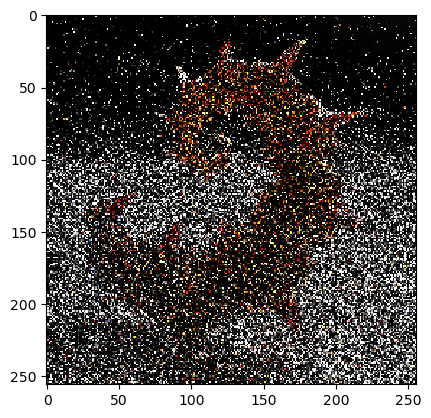

128


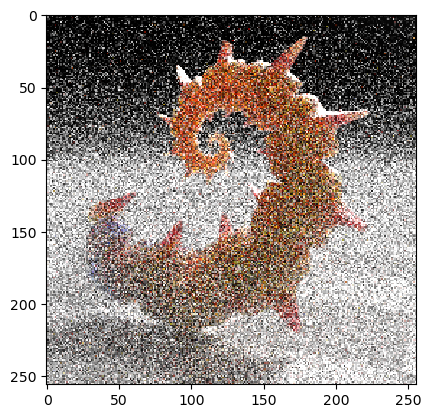

2048


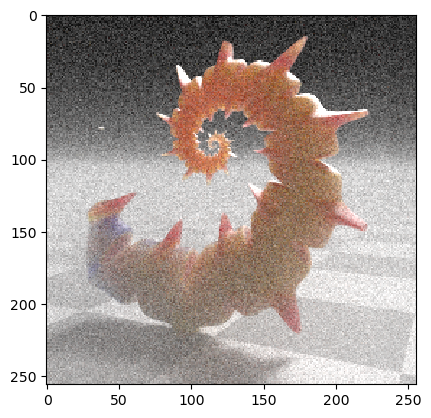

32768


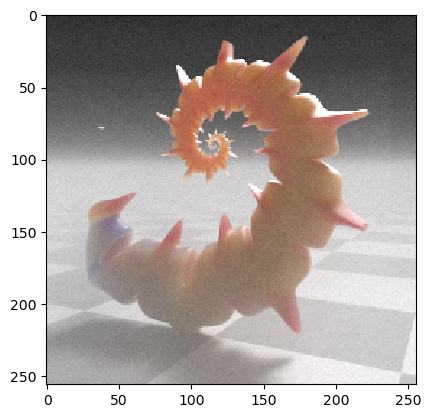

converged


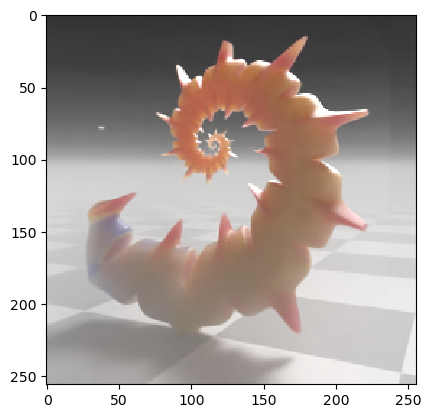

In [2]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    data = data.reshape((n, 3, w, h))
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i)
            frame = np.clip(frame, 0.0, 1.0) ** (1.0/2.2)
            frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
            plt.figure()
            plt.imshow(frame)
            plt.show()
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        frame = np.clip(ref, 0.0, 1.0)
        frame = frame ** (1.0/2.2)
        frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
        print("converged")
        plt.figure()
        plt.imshow(frame)
        plt.show()
    return {
        'w': w,
        'h': h,
        'data': data,
        'ref': ref
    }


_ = load_data_file("6d5a19f6_16_256_256.bin", True)

torch.Size([32, 3, 64, 64])


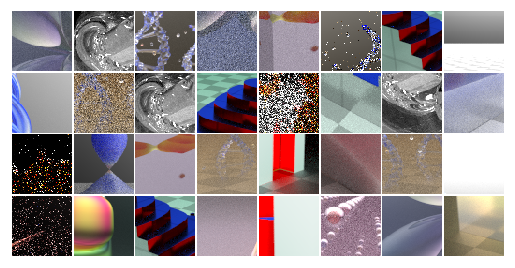

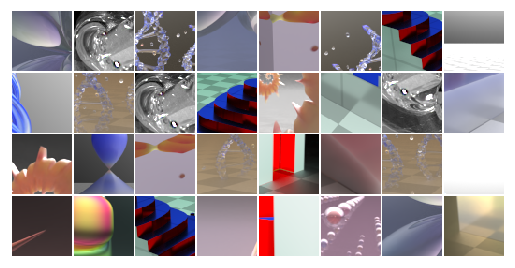

In [3]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 64
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s)
            y = np.random.randint(0, self.data[k]['h']-s)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = round(0.6 * np.random.random()**4 * 2**n + 0.5)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=32,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def relu(x):
    return F.relu(x, inplace=True)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n = 16
        self.convi = conv3(3, n)
        self.conv11 = conv3(n, n)
        self.conv12 = conv3(n, n)
        self.conv21 = conv3(n, n)
        self.conv22 = conv3(n, n)
        self.conv31 = conv3(n, n)
        self.conv32 = conv3(n, n)
        self.conv41 = conv3(n, n)
        self.conv42 = conv3(n, n)
        self.convo = conv3(n, 3)

    def forward(self, input):
        x = input
        # input
        ci = self.convi(x)
        x = relu(ci)
        # residual 1
        c11 = self.conv11(x)
        x = relu(c11)
        c12 = self.conv12(x)
        x1 = ci + c12
        # residual 2
        c21 = self.conv21(x1)
        x = relu(c21)
        c22 = self.conv22(x)
        x2 = x1 + c22
        # residual 3
        c31 = self.conv31(x2)
        x = relu(c31)
        c32 = self.conv32(x)
        x3 = x2 + c32
        # residual 4
        c41 = self.conv41(x3)
        x = relu(c41)
        c42 = self.conv32(x)
        x4 = x3 + c42
        # output
        co = self.convo(x4)
        return co

model = Model().to(device)
print(model)

Model(
  (convi): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv21): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv22): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv31): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv32): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv41): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv42): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convo): Conv2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


512 0.0465800017118454
1024 0.030252261087298393
1536 0.02328418754041195
2048 0.016145464032888412
2560 0.00902276486158371
3072 0.013050536625087261
3584 0.015256838873028755
4096 0.014340652152895927
4608 0.013931762427091599
5120 0.01154889166355133
5632 0.022563500329852104
6144 0.01991564780473709
6656 0.010569894686341286
7168 0.00798771157860756
7680 0.015889357775449753
8192 0.013398243114352226


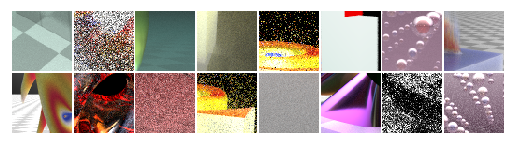

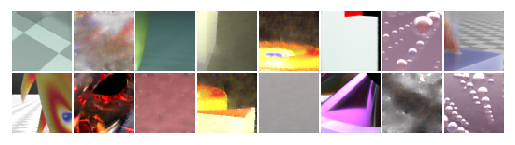

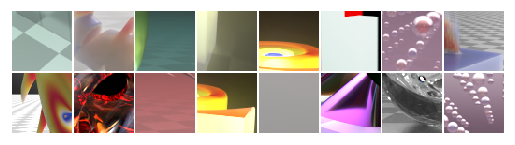

8704 0.005994309671223164
9216 0.013840566389262676
9728 0.012729941867291927
10240 0.028311189264059067
10752 0.007681639399379492
11264 0.013435153290629387
11776 0.011375296860933304
12288 0.009231921285390854
12800 0.013473046943545341
13312 0.013985417783260345
13824 0.008427675813436508
14336 0.01162765920162201
14848 0.01003031712025404
15360 0.008710461668670177
15872 0.01034319493919611
16384 0.012368408963084221


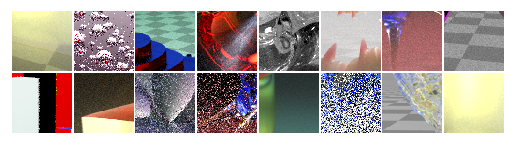

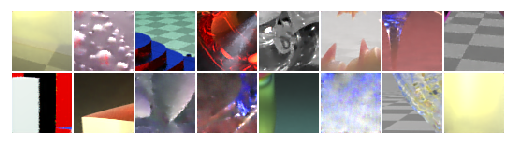

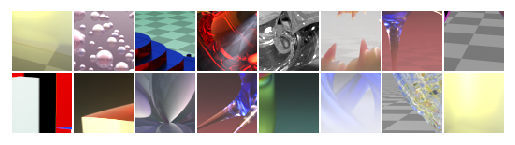

16896 0.018143294379115105
17408 0.014368927106261253
17920 0.008943744003772736
18432 0.016399290412664413
18944 0.015174332074820995
19456 0.005081212148070335
19968 0.01253943145275116
20480 0.011632311157882214
20992 0.012072959914803505
21504 0.010494042187929153
22016 0.006840329617261887
22528 0.02150021120905876
23040 0.01886104606091976
23552 0.008971456438302994
24064 0.0063467989675700665
24576 0.014336878433823586


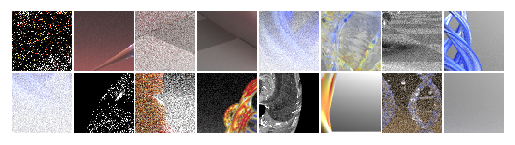

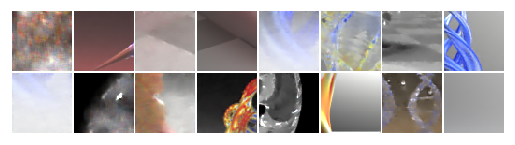

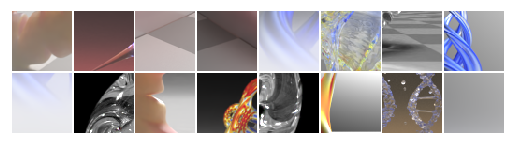

25088 0.015778597444295883
25600 0.01467065792530775
26112 0.01295250654220581
26624 0.015113607048988342
27136 0.011890209279954433
27648 0.018867336213588715
28160 0.006074916571378708
28672 0.011502271518111229
29184 0.022726692259311676
29696 0.0064225210808217525
30208 0.01197939645498991
30720 0.02287360280752182
31232 0.012125599198043346
31744 0.013454053550958633
32256 0.0098412549123168
32768 0.006470128428190947


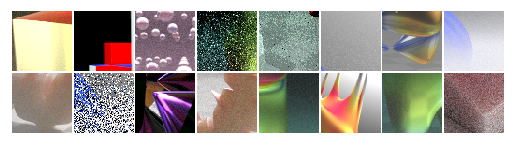

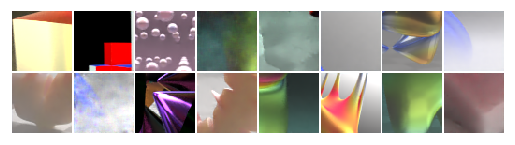

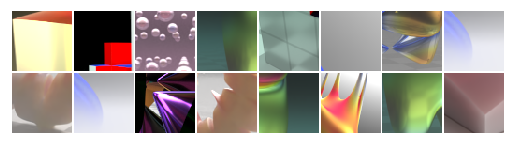

In [5]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005
)

def lossfun(output, reference, input):
    return torch.mean(torch.abs(output-reference))

batch_count = 0
for epoch in range(1):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**19), batch_size=16, shuffle=True)
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        optimizer.zero_grad()
        output = model(x)
        loss = lossfun(output, y, x)
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 512 == 0:
            print(batch_count, loss.item())
        if batch_count % 8192 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp(output.detach())-1)
            plot_imgs(torch.exp(y)-1)


In [6]:
torch.save(model, "model1.pth")

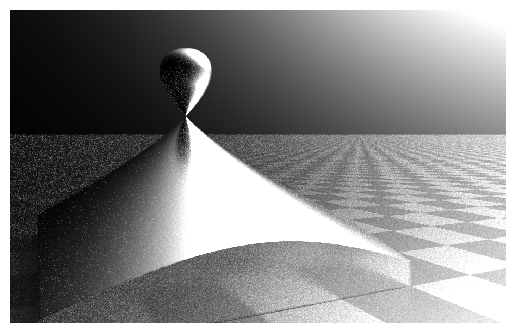

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


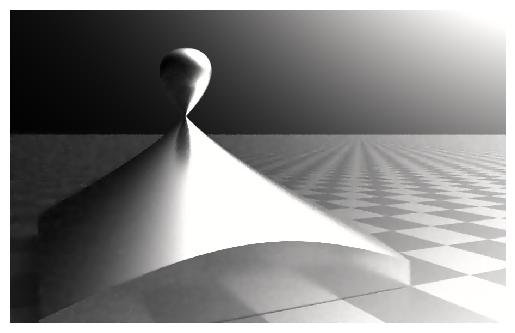

In [7]:
from PIL import Image

def load_image(filename):
    image = Image.open(filename).convert("RGB")
    image = np.array(image)
    w, h = image.shape[:2]
    image = image[:(w//16)*16, :(h//16)*16, :].astype(np.float32)/255.0
    image = torch.tensor(image, device=device).permute(2, 0, 1)
    return image


def plot_img(x):
    plt.figure()
    plt.imshow(x.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.show()


x = load_image("test/noisy00.png")
x = x.reshape(1, *x.shape)

plot_img(x[0])

with torch.no_grad():
    x = torch.log(x+1)
    y = model(x)
    y = torch.exp(y)-1

plot_img(y[0])